# <font color=black> Analysis - ICA vs iCAP in the spinal cord </font>
<hr style="border:1px solid black">

**The goal of this analysis is to investigate the reproducibility of spinal networks extracted using different methods and datasets.**

**METHODS CONSIDERED:**
- Independent Component Analysis – called `ica` in this script
- Innovation-driven CoActivation Pattern analysis – called `icap` in this script

**DATASETS:**
- A dataset covering C1 to C8 spinal levels, with a resolution of 1.6x1.6x4mm<sup>3</sup>  and a TR of 1.55s – called `mtl` in this script
- A dataset covering C5 to C8 spinal levels, with a resolution of 1x1x3mm<sup>3</sup> and a TR of 2.5s – called `gva` in this script

**ANALYSES:**
- _**Qualitative:**_ matching & visualization of one or two set(s) of components
- _**Quantitative:**_
    * Analysis of spatial similarity (for a single K, or across multiple Ks)
    * Distribution across axial subdvisions (D,V,L,R) for different Ks

In [1]:
import sys,json

sys.path.append('/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/code/')

from plotting import Plotting
from spine_only_analysis import SpineOnlyAnalysis

%matplotlib inline
%load_ext autoreload
%autoreload 2

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


# Initialization

### Load configuration file 

In [2]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../config/config_spine_only_CL.json') as config_file:
    config = json.load(config_file)

# Figure 1  – Robusness K= high granulosity

## `mtl` dataset
### Qualitative evaluation

In [3]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_mtl_robustness_1 = {'k':36, 'dataset':'mtl', 'analysis':'ica'}
params_qual_mtl_robustness_2 = {'k':36, 'dataset':'mtl', 'analysis':'icap'}
config["templates"]["spinalcord"]= "/templates/PAM50/template/T2w_group_mean.nii.gz",
plotting_mtl = Plotting(config,'spinalcord',params1=params_qual_mtl_robustness_2,params2=params_qual_mtl_robustness_1)


/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_spine_only/mtl/spinalcord//K_36/comp_zscored/*_z.nii*
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/mtl/spinalcord//K_36/comp_zscored/*4D_z*


The plotting will be display in flip orientation (Right > left)
COMPUTING SIMILARITY WITH METHOD: Dice
...Compute similarity between pairs of components
...Ordering components based on maximum weight matching
DONE!


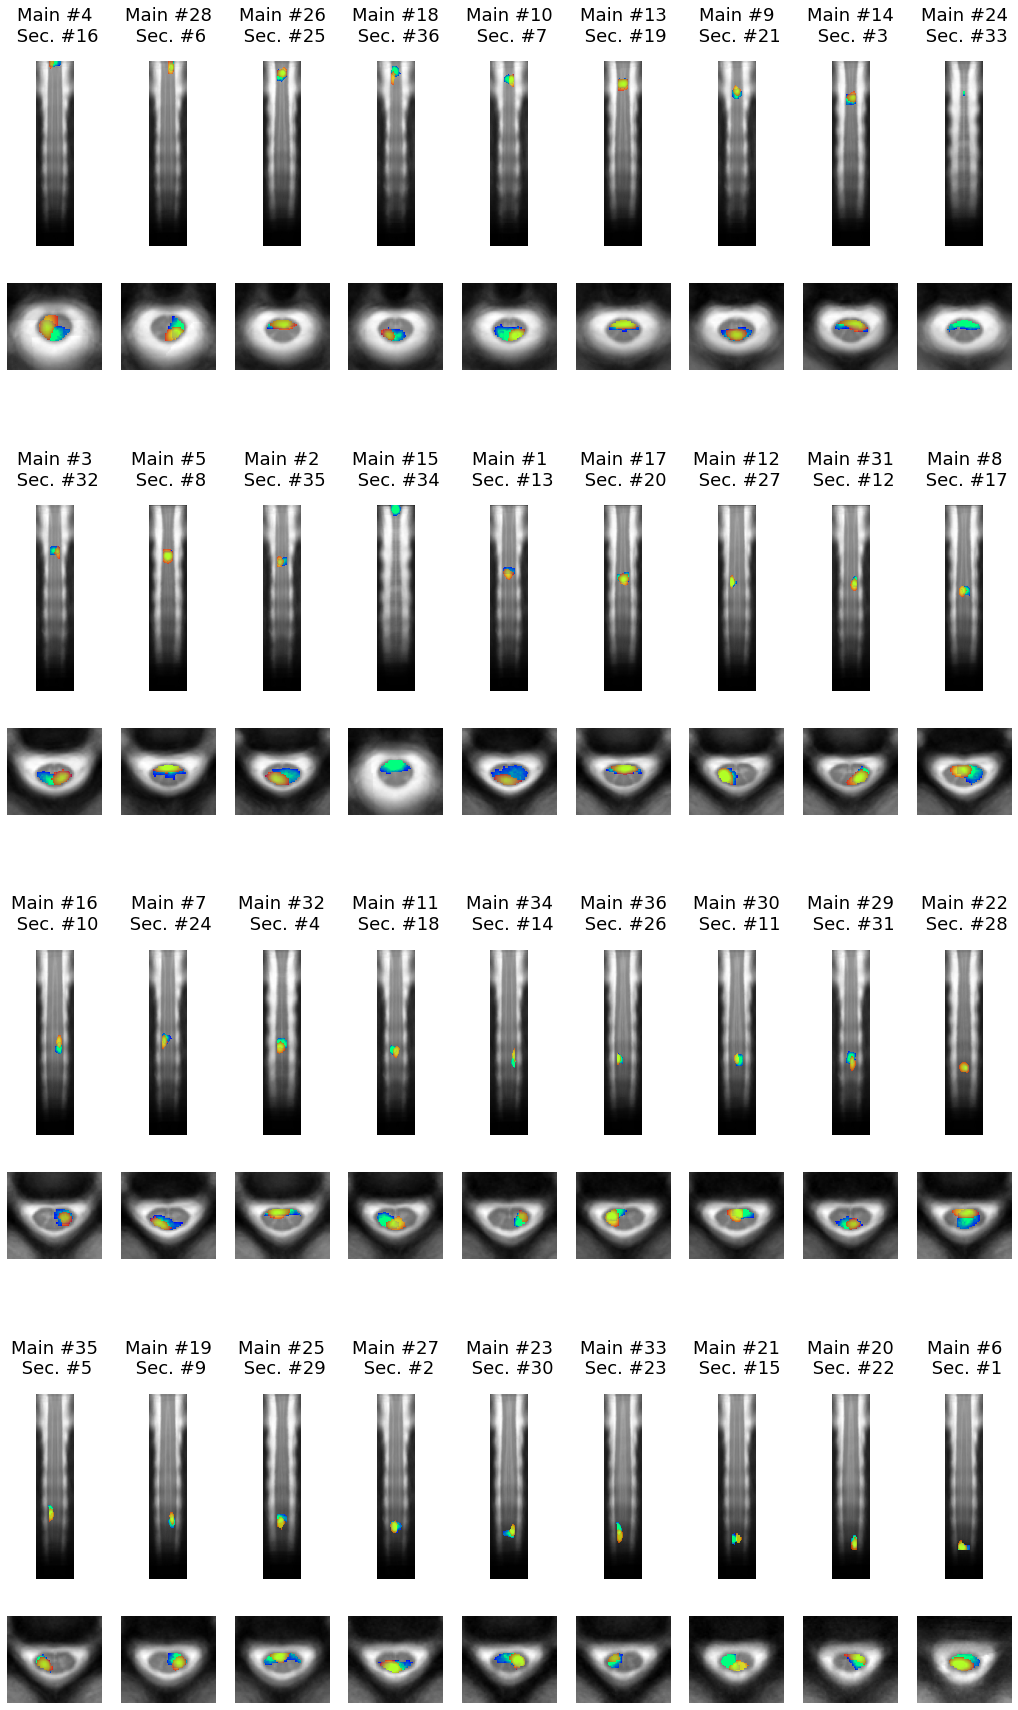

In [4]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_group_mean_resampled.nii.gz"
plotting_mtl.sc_plot(show_spinal_levels=False, k_per_line=9, lthresh=3, uthresh=6, save_results=False, similarity_method='Dice')

_Note: the component numbers refer to the ones of the original datasets (i.e., before any type of reordering)_

### Quantitative evaluation

METHOD 1: Comparing two sets of components at specific K values 
mtl_ica at K = 36 vs mtl_icap at K = 36 

The mean similarity is 0.54


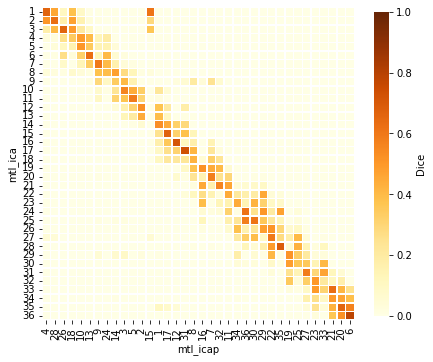

In [48]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
params_quant_mtl_robustness_1 = {'k_range':range(36,37), 'dataset':'mtl', 'analysis':'ica'}
params_quant_mtl_robustness_2 = {'k_range':range(36,37), 'dataset':'mtl', 'analysis':'icap'}
spine_analysis_mtl = SpineOnlyAnalysis(config,params1=params_quant_mtl_robustness_1 ,params2=params_quant_mtl_robustness_2)
spine_analysis_mtl.spatial_similarity(k1=36,similarity_method='Dice')

## `gva` dataset
### Qualitative evaluation

In [50]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
params_qual_gva_robustness_1 = {'k':20, 'dataset':'gva', 'analysis':'ica'}
params_qual_gva_robustness_2 = {'k':20, 'dataset':'gva', 'analysis':'icap'}

plotting_gva = Plotting(config,'spinalcord',params1=params_qual_gva_robustness_2,params2=params_qual_gva_robustness_1)


/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_spine_only/gva/spinalcord//K_20/comp_zscored/*_z.nii*
/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//ICA/results_spine_only/gva/spinalcord//K_20/comp_zscored/*4D_z*


The plotting will be display in flip orientation (Right > left)


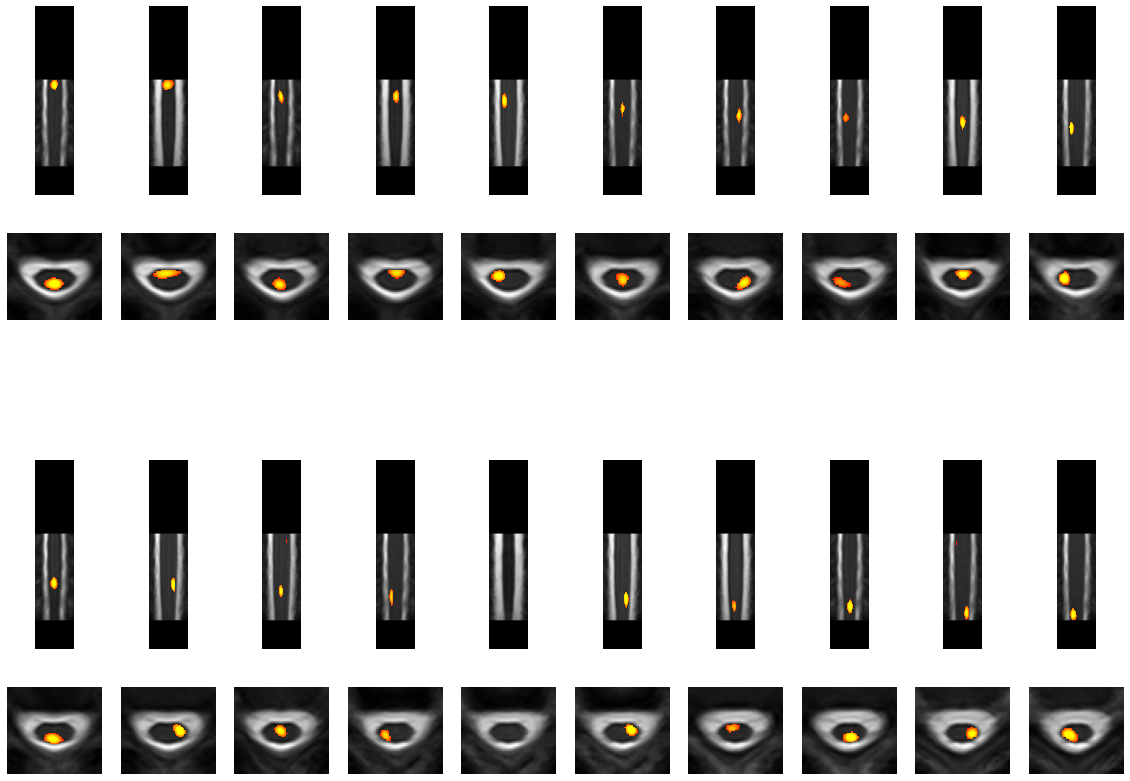

In [47]:
config["templates"]["spinalcord"]="/templates/PAM50/template/T2w_gva_group_mean_resampled.nii.gz"
plotting_gva.sc_plot(show_spinal_levels=False, k_per_line=10, lthresh=2.6, uthresh=5, save_results=False, similarity_method='Dice')

METHOD 1: Comparing two sets of components at specific K values 
gva_ica at K = 20 vs gva_icap at K = 20 

The mean similarity is 0.46


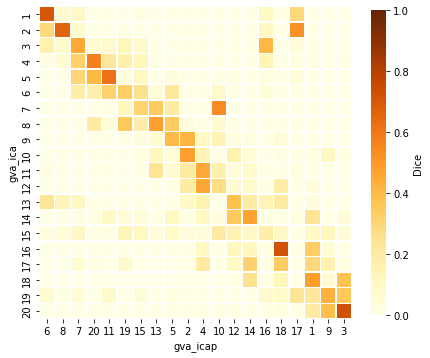

In [52]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
params_quant_gva_robustness_1 = {'k_range':range(20,21), 'dataset':'gva', 'analysis':'ica'}
params_quant_gva_robustness_2 = {'k_range':range(20,21), 'dataset':'gva', 'analysis':'icap'}
spine_analysis_mtl = SpineOnlyAnalysis(config,params1=params_quant_gva_robustness_1 ,params2=params_quant_gva_robustness_2)
spine_analysis_mtl.spatial_similarity(k1=20,similarity_method='Dice')

### Analyze spatial similarity

#### Matching is not great for low K, but good otherwise

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_gva.spatial_similarity(k1=5,similarity_method='Dice')

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_gva.spatial_similarity(k1=10,similarity_method='Dice')

In [ ]:
# Similarity has been computed using 'Dice', but 'Cosine' or 'Euclidean distance' could be used instad
spine_analysis_gva.spatial_similarity(k1=20,similarity_method='Dice')

In [ ]:
spine_analysis_gva.spatial_similarity(k_range=range(4,41),thresh=1.5, similarity_method='Dice', verbose=False)

In [ ]:
spine_analysis_gva.spatial_similarity(k_range=range(4,11),thresh=2, similarity_method='Dice', verbose=False)

### Investigate axial distribution for different Ks

#### Distributions seem a bit different: <font color=red> => TO EXPLORE </font>
- ICA: a lot of LR subdivisions early on
- iCAP: mostly DV </br>

In [ ]:
distribution_gva_ica = spine_analysis_gva.k_axial_distribution(spine_analysis_gva.name1, thresh=2, vox_percentage=70, verbose=False)

In [ ]:
distribution_gva_icap = spine_analysis_gva.k_axial_distribution(spine_analysis_gva.name2, thresh=2, vox_percentage=70, verbose=False)

### `MTL` dataset

### Instantiate class

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_mtl_1 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'ica'}
params_quant_mtl_2 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'icap'}

spine_analysis_mtl = SpineOnlyAnalysis(config,params1=params_quant_mtl_1,params2=params_quant_mtl_2)

### Analyze spatial similarity

#### Matching is a bit better for low K, and still good for high K!

In [ ]:
spine_analysis_mtl.spatial_similarity(k1=9,similarity_method='Dice')

In [ ]:
spine_analysis_mtl.spatial_similarity(k1=18,similarity_method='Dice')

In [ ]:
spine_analysis_mtl.spatial_similarity(k1=36,similarity_method='Dice')

In [ ]:
spine_analysis_mtl.spatial_similarity(k_range=range(4,11),thresh=2,similarity_method='Dice', verbose=False)

### Investigate axial distribution for different Ks

#### Distributions seem a bit different: <font color=red> => TO EXPLORE </font>
- ICA: LR subdivisions early on
- iCAP: mostly DV </br>

_Note: here, no Q subdivisions... is it because we have more levels or because of the lower resolution?_

In [ ]:
distribution_mtl_ica = spine_analysis_mtl.k_axial_distribution(spine_analysis_mtl.name1, thresh=2, vox_percentage=70, verbose=False)

In [ ]:
distribution_mtl_icap = spine_analysis_mtl.k_axial_distribution(spine_analysis_mtl.name2, thresh=2, vox_percentage=70, verbose=False)

## Between-dataset comparison

### `ICA` method

### Instantiate class

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_ica_1 = {'k_range':range(4,41), 'dataset':'gva', 'analysis':'ica'}
params_quant_ica_2 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'ica'}

spine_analysis_ica = SpineOnlyAnalysis(config,params1=params_quant_ica_1,params2=params_quant_ica_2)

### Analyze spatial similarity

#### Very bad for low K, good for higher!
Note: here I have chosen $K \times 2$ for `mtl` compared to `gva`, to match the difference in spinal levels that are covered.

In [ ]:
spine_analysis_ica.spatial_similarity(k1=5,k2=9,similarity_method='Dice')

In [ ]:
spine_analysis_ica.spatial_similarity(k1=10,k2=18,similarity_method='Dice')

In [ ]:
spine_analysis_ica.spatial_similarity(k1=20,k2=36,similarity_method='Dice')

### `iCAP` method

### Instantiate class

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
params_quant_icap_1 = {'k_range':range(4,41), 'dataset':'gva', 'analysis':'icap'}
params_quant_icap_2 = {'k_range':range(4,41), 'dataset':'mtl', 'analysis':'icap'}

spine_analysis_icap = SpineOnlyAnalysis(config,params1=params_quant_icap_1,params2=params_quant_icap_2)

### Analyze spatial similarity

#### Not great for low K, good for high K

In [ ]:
spine_analysis_icap.spatial_similarity(k1=5,k2=9,similarity_method='Dice')

In [ ]:
spine_analysis_icap.spatial_similarity(k1=20,k2=36,similarity_method='Dice')

# Explore subject-specific maps

### Visualization

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
for dataset in ['mtl', 'gva']:
    for sub in config['list_subjects'][dataset]:
        params_qual_1 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap', 'subject':'sub-'+sub}
        #params_qual_2 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap'}

        plotting = Plotting(config,'spinalcord',params1=params_qual_1)
        #plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=params_qual_2)
        plotting.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.5, uthresh=3, save_results=True, similarity_method='Dice')
        
        

# Explore durations

### Visualization

In [ ]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis
timings = {}
timings['mtl'] = ['1min','2min','3min','4min','5min','6min']
timings['gva'] = ['1min','2min','3min','4min','5min','6min','9min','12min','15min']

for dataset in ['mtl', 'gva']:
    for dur in timings[dataset]:
        params_qual_1 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap_duration', 'duration':dur}
        #params_qual_2 = {'k':(9 if dataset == 'mtl' else 5), 'dataset':dataset, 'analysis':'icap'}

        plotting = Plotting(config,'spinalcord',params1=params_qual_1)
        #plotting = Plotting(config,'spinalcord',params1=params_qual_1,params2=params_qual_2)
        plotting.sc_plot(show_spinal_levels=False, k_per_line=(9 if dataset == 'mtl' else 5), lthresh=1.5, uthresh=3, save_results=True, similarity_method='Dice')
        
        

### Assessment of similarity 

#### 'gva' dataset

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="gva"
t_range=[1,2,3,4,5,6,9,12,15]
params_dur_gva_1 = {'k_range':range(5,6),'dataset':dataset, 'analysis':"icap_duration",'t_range':[15]}
params_dur_gva_2 = {'k_range':range(5,6), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range}

spine_analysis_duration_gva = SpineOnlyAnalysis(config,params1=params_dur_gva_1,params2=params_dur_gva_2)
spine_analysis_duration_gva.spatial_similarity(k1=5,t_range1=15,t_range2=t_range,similarity_method='Dice',verbose=False)

In [ ]:
# Define parameters for the datasets to compare
# Each param dict has 3 values: k_range, dataset and analysis
dataset="mtl"
t_range=[1,2,3,4,5,6]
params_dur_mtl_1 = {'k_range':range(9,10),'dataset':dataset, 'analysis':"icap_duration",'t_range':[6]}
params_dur_mtl_2 = {'k_range':range(9,10), 'dataset':dataset, 'analysis':"icap_duration", 't_range': t_range}

spine_analysis_duration_mtl = SpineOnlyAnalysis(config,params1=params_dur_mtl_1,params2=params_dur_mtl_2)
spine_analysis_duration_mtl.spatial_similarity(k1=9,t_range1=6,t_range2=t_range,similarity_method='Dice',save_results=True,verbose=False)

# Explore individual maps

In [ ]:
params_indiv_gva = {'k_range':range(5,6),'dataset':'gva', 'analysis':'icap'}
params_indiv_mtl = {'k_range':range(9,10),'dataset':'mtl', 'analysis':'icap'}
spine_analysis_indiv = SpineOnlyAnalysis(config, params1=params_indiv_gva, params2=params_indiv_mtl, load_subjects=True)

In [ ]:
spine_analysis_indiv.subject_distribution(spine_analysis_indiv.name2,k=9,thresh=1.5)